# Advanced Lane Lines Project



## Camera Calibration 

This is the routine to calibrate de camera.

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

def show_2_images(img_1, title_1, img_2, title_2, cmap_value=None, convert_1=False, convert_2=False):
    
    if convert_1 == True:
        img_1=cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
    if convert_2 == True:
        img_2=cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
        
    
    %matplotlib inline
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img_1,cmap=cmap_value)
    ax1.set_title(title_1, fontsize=30)
    ax2.imshow(img_2,cmap=cmap_value)
    ax2.set_title(title_2, fontsize=30)
    
def show_3_images(img_1, title_1, img_2, title_2, img_3, title_3, cmap_value=None, convert=False):
    
    if convert == True:
        img_1=cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
        img_2=cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
        img_3=cv2.cvtColor(img_3, cv2.COLOR_BGR2RGB)
    
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(12, 9))
    f.tight_layout()
    ax1.imshow(img_1,cmap=cmap_value)
    ax1.set_title(title_1, fontsize=50)
    ax2.imshow(img_2,cmap=cmap_value)
    ax2.set_title(title_2, fontsize=50)
    ax3.imshow(img_3,cmap=cmap_value)
    ax3.set_title(title_3, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    
    

def calibrate_camera(path_to_calibrate_images, show=False , save=False):
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    images = glob.glob(path_to_calibrate_images)


    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

   
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            img_teste = cv2.imread('test_images/test1.jpg')
            img_size = (img_teste.shape[1], img_teste.shape[0])
            ret_, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
            
            if show == True:
                cv2.drawChessboardCorners(img, (9,6), corners, ret)
                cv2.imshow('img', img)
                cv2.waitKey(500)
                
            if save == True:
                dist_pickle = {}
                dist_pickle["mtx"] = mtx
                dist_pickle["dist"] = dist
                pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )
            
    return mtx, dist

def undist(img,mtx,dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx) 
    return dst

def bird_view (img):
    
    img_size=(img.shape[1],img.shape[0])
    src_pts = np.float32([[245,720],[590,450],[685,450],[1060,720]])
    dst_pts = np.float32([[245,720],[170,0],[1060,0],[1040,720]])
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    Minv = cv2.getPerspectiveTransform(dst_pts, src_pts)
    bird_view_image = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    
    return bird_view_image, Minv

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

   
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    
    return binary_output

def RGB_Split(img):
    R=img[:,:,0]
    G=img[:,:,1]
    B=img[:,:,2]
    
    return R,G,B

def HLS_Split(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H=hls[:,:,0]
    L=hls[:,:,1]
    S=hls[:,:,2]
    
    return H,L,S

def thresh_color_channel(ch, thresh_min=0, thresh_max=255):
    binary = np.zeros_like(ch)
    binary[(ch >= thresh_min) & (ch <= thresh_max)] = 1
    
    return binary








mtx, dist = calibrate_camera("camera_cal/*.jpg", show=False, save=False)


In [3]:
def lanes_curvature (ploty, left_fit, right_fit):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return int(left_curverad), int(right_curverad)

In [4]:
def find_lanes(binary_warped, show = False):
     
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
     
    
    #Show Output
    if show == True:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
       
    mid_pos = (leftx_base + rightx_base)/2
    
    
    return binary_warped, left_fit, right_fit, mid_pos
    
    

    

In [5]:
def find_next_lane(binary_warped, left_fit, right_fit, mid_pos, show = False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    
    
    l_rad,r_rad = lanes_curvature(ploty, left_fit, right_fit)
    
   
    
    car_position = (left_fitx[500]+right_fitx[500])/2
    pix_meters =  '{0:.3g}'.format(((car_position-mid_pos)*3.7)/(right_fitx[500] - left_fitx[500]))
    
      
    
    if show == True:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        
    
    return binary_warped, left_fitx, right_fitx, ploty, l_rad, r_rad, pix_meters
    
    

In [6]:
def draw_lines(undist,warped, Minv, left_fitx, right_fitx, ploty,pix_meters, show = False, l_rad=0, r_rad=0):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    cv2.putText(result,"Left Rad: " + str(l_rad) + "m", (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(result,"Right Rad: " + str(r_rad) + "m", (100,200), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(result,"Center Error: " + str(pix_meters) + "m", (100,300), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    if show == True:
        plt.imshow(result)
        
    return result

In [7]:
def color_gradient (img):  
    
    img = undist(img, mtx, dist)
    _,_,s_channel = HLS_Split(img)
    s_binary = thresh_color_channel(s_channel, thresh_min=100, thresh_max=255)
      
    
    sobel_binary = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=150)
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255))  
    
    combined_binary = (sobel_binary | s_binary)
    
    return img,combined_binary


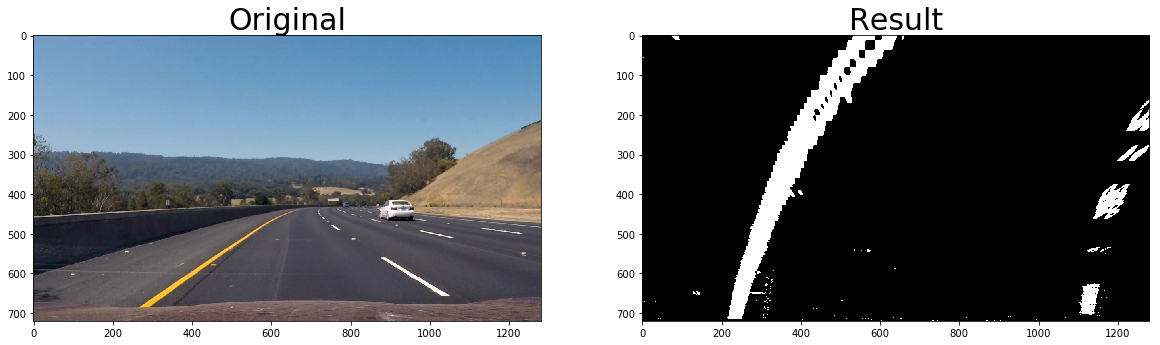

In [14]:
img = cv2.imread('test_images/test3.jpg')

undistorced = undist(img, mtx, dist)

_,result = color_gradient(img)

result, Minv  = bird_view(result)

show_2_images(img, "Original", result, "Result",cmap_value="gray",convert_1=True, convert_2=False)



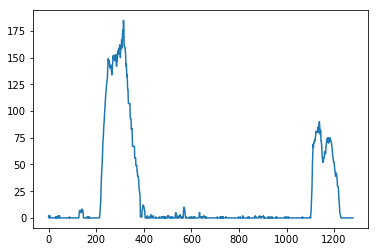

In [15]:
histogram = np.sum(result[result.shape[0]//2:,:], axis=0)
plt.plot(histogram)

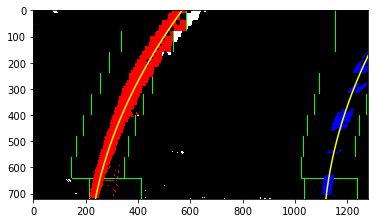

In [16]:
out, left_fit, right_fit,mid_pos=find_lanes(result,show=True)

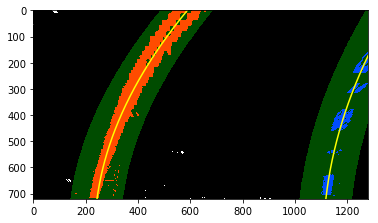

In [17]:
binary_warped, left_fitx, right_fitx, ploty,_,_,pix_meters = find_next_lane(out, left_fit, right_fit,mid_pos,show=True)

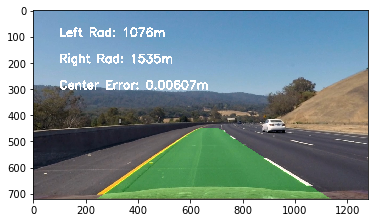

In [20]:
img = cv2.imread('test_images/test3.jpg')

undistorced,result = color_gradient(img)

result, Minv  = bird_view(result)

binary_warped, left_fit, right_fit,mid_pos = find_lanes(result, show = False)
    
binary_warped, left_fitx, right_fitx, ploty,left_rad,right_rad,pix_meters = find_next_lane(binary_warped, left_fit, right_fit,mid_pos, show = False)

output_image=draw_lines(undistorced,result, Minv, left_fitx, right_fitx, ploty,pix_meters, show=True, l_rad=left_rad, r_rad=right_rad)

output_image=cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

plt.imshow(output_image)

In [12]:

def advanced_lane_lines(image):
    
    undistorced,result = color_gradient(image)

    result, Minv  = bird_view(result)

    binary_warped, left_fit, right_fit,mid_pos = find_lanes(result, show = False)
    
    binary_warped, left_fitx, right_fitx, ploty, left_rad, right_rad,pix_meters = find_next_lane(binary_warped, left_fit, right_fit,mid_pos, show = False)

    result=draw_lines(undistorced,result, Minv, left_fitx, right_fitx, ploty, pix_meters, show=True, l_rad=left_rad, r_rad=right_rad)
    
    
    
    return result

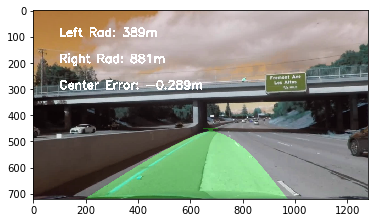

In [13]:
image=cv2.imread("test_images/frame1.jpg")
_=advanced_lane_lines(image)

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    
    result=advanced_lane_lines(image)
   

    return result


MoviePy: building video file Project_ADVLANES.mp4
----------------------------------------

Writing video into Project_ADVLANES.mp4
Done writing video in Project_ADVLANES.mp4 !                             
Your video is ready !
CPU times: user 5min 4s, sys: 13.2 s, total: 5min 17s
Wall time: 3min 47s


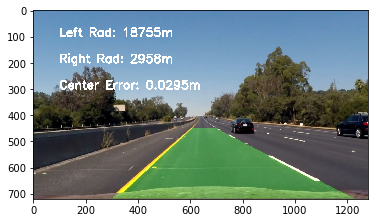

In [15]:
white_output = 'Project_ADVLANES.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
#trace_lanes('test_images/solidWhiteRight.jpg')

#print(type(white_clip))

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))
